<div class="div_image pull-right">
    <div class = "image image_topic pull-right">
        <img src = "https://i.imgur.com/EGtMXKh.jpg?1">
    </div>
</div>

# <b>Capstone Project: Choosing the best heroes to climb the rankings (Neural Network)</b>


In Part 3, I tried out several machine learning models to predict the winrate of the data. In this part, I will build a neural network to determine if it can better predict match wins.


# Import Libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix, round
from tensorboard.plugins.hparams import api as hp
import keras_tuner
from keras.callbacks import TensorBoard

import datetime

import shap

import warnings

warnings.filterwarnings('ignore')


# Data Preprocessing


In [2]:
model_df = pd.read_csv("Data\preprocessed_data.csv")


In [3]:
model_df.head()

,radiant_win,R1,R10,R100,R101,R102,R103,R104,R105,R106,...,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99
0,False,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,True,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,True,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


We will first load in our split data that we have trained earlier.

In [4]:
npzfile = np.load('Data\data.npz')

X_train = npzfile['X_train']
X_test = npzfile['X_test']
y_train = npzfile['y_train']
y_test = npzfile['y_test']
data_unseen = npzfile['data_unseen']

# Tensorflow Model


I will be using tensorflow to help us build our neural network model. The network input is a binary vector of 246 values, which is then divided into two parts - _x_radiant, and x_dire_ - using Keras Lambda Layers, then two Dense layers - _hero_layer_1 and hero_layer_2_ - are applied to each of the lambda layers. This is necessary to remove the influence of the heroes on the "dire" and "radiant" team accordingly. The resulting vectors are then concatenated. The vectors are then put through two dropout layers, before alternating three cycles of hidden layers and dropout layers. The output layer is a Dense Layer with 1 neuron and Sigmoid Activation function.

I will be using 'adam' as my optimiser and optimise for accuracy and will be using Keras Tuner's HyperBand to optimise the hyperparameters.


In [5]:
# Tensorflow model - Reference from 'Machine Learning Approaches to Choose Heroes in Dota 2' by Iullia Porokhnenko, Petr Polezhaev and Alexander Shukhman

# Function to create model
def create_model(hp):
    # Input Layer

    # to determine the shape of the input
    input_columns = int(len(model_df.columns)-1)
    input = Input(shape=(input_columns,))

    # int value between min and max value for the different units
    dense_units = hp.Int('dense_units', min_value=96, max_value=224, step=32)
    hidden_units_1 = hp.Int(
        'hidden_units_1', min_value=128, max_value=224, step=32)
    hidden_units_2 = hp.Int(
        'hidden_units_2', min_value=96, max_value=192, step=32)
    hidden_units_3 = hp.Int(
        'hidden_units_3', min_value =64, max_value=160, step=32)
    # dropout rate of 0.3 to 0.5
    dropout_1 = hp.Choice('dropout_1', [0.3, 0.4, 0.5])
    dropout_2 = hp.Choice('dropout_2', [0.3, 0.4, 0.5])

    # different learning rate of 0.0005 to 0.002
    learning_rate_1 = hp.Choice('learning_rate_1', [0.001, 0.002, 0.0005])

    # Lamda Layer for x_radiant heroes
    x_radiant = Lambda(lambda x: x[:, :int(input_columns/2)])(input)

    # Lamda Layer for x_dire heroes
    x_dire = Lambda(lambda x: x[:, int(input_columns/2):])(input)

    # Dense Layer of Number of Units in First Layer Neurons

    hero_layers_1 = Dense(dense_units, activation='relu')

    # Apply to x_dire

    dire_layer_1 = hero_layers_1(x_dire)

    # Apply to x_radiant
    radiant_layer_1 = hero_layers_1(x_radiant)

    # Apply Dense Layer 1 again

    hero_layers_2 = Dense(dense_units, activation='relu')

    # Apply to dire layer 1

    dire_layer_2 = hero_layers_2(dire_layer_1)

    # Apply to radiant layer 2

    radiant_layer_2 = hero_layers_2(radiant_layer_1)

    # Combine the 2 layers

    conc = concatenate([dire_layer_2, radiant_layer_2])

    # Apply 2 dropout regularization layers

    dropout1 = Dropout(dropout_1)(conc)
    dropout2 = Dropout(dropout_2)(dropout1)

    # Apply hidden layer 1

    hidden1 = Dense(hidden_units_1, activation='relu')(dropout2)

    # Dropout Regularization 1

    dropout_hidden1 = Dropout(dropout_2)(hidden1)

    # Apply hidden layer 2

    hidden2 = Dense(hidden_units_2, activation='relu')(dropout_hidden1)

    #Dropout Regularization 2

    dropout_hidden2 = Dropout(dropout_2)(hidden2)

    #Apply hidden layer 3

    hidden3 = Dense(hidden_units_3, activation='relu')(dropout_hidden2)

    # Output Layer
    output = Dense(1, activation='sigmoid')(hidden3)

    # Final Model

    model = Model(inputs=input, outputs=output)

    opt = Adam(learning_rate=learning_rate_1)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    return model


In [6]:
# Creating our model
create_model(keras_tuner.HyperParameters())


I will set the tuner to optimise for validation accuracy. I will also set a max epoch value of 50 and log the results.

In addition, I will create a stop-early function to also ensure that our model does not overfit. I have set the patience function for the validation accuracy to 2, which indicates that each trial will stop early should the validation accuracy decreases two times in a row. This will provide some leeway for the model to learn during the training process.


In [7]:
# Creating our tuner and boundaries
tuner = keras_tuner.BayesianOptimization(
    hypermodel=create_model,
    objective="val_accuracy",
    max_trials=50,
    seed=42,
    alpha=0.0001,
    beta = 2.6,
    overwrite=True,
    project_name="hyperparameter_search_results",
)


In [8]:
# Creating a stop-early function
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)


I will now instantiate the tuner onto the model to search through the best parameters.


In [9]:
# Instantiate the tuner onto the model
tuner.search(X_train, y_train, validation_data=(X_test, y_test),
             callbacks=[stop_early], epochs=50, batch_size=256)


Trial 50 Complete [00h 00m 16s]
val_accuracy: 0.5532087087631226

Best val_accuracy So Far: 0.5569201707839966
Total elapsed time: 00h 21m 03s
INFO:tensorflow:Oracle triggered exit


In [10]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Dense Units is {best_hps['dense_units']}")
print(f"Best Hidden 1 Units is {best_hps['hidden_units_1']}")
print(f"Best Hidden 2 Units is {best_hps['hidden_units_2']}")
print(f"Best Hidden 3 Units is {best_hps['hidden_units_3']}")
print(f"Best Dropout 1 Regularisation is {best_hps['dropout_1']}")
print(f"Best Dropout 2 Regularisation is {best_hps['dropout_2']}")
print(f"Best Learning Rate is {best_hps['learning_rate_1']}")


Best Dense Units is 192
Best Hidden 1 Units is 128
Best Hidden 2 Units is 128
Best Hidden 3 Units is 96
Best Dropout 1 Regularisation is 0.3
Best Dropout 2 Regularisation is 0.4
Best Learning Rate is 0.001


From the above, we can see the best hyperparameters for our model. We will then train our model with these hyperparameters and plot the graph to show the loss and accuracy.


In [11]:
# log the files to tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=30, validation_data=(
    X_test, y_test), callbacks=[tensorboard_callback, stop_early], batch_size=128)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/30
927/927 [==============================] - 6s 5ms/step - loss: 0.6942 - accuracy: 0.5012 - val_loss: 0.6927 - val_accuracy: 0.5031
Epoch 2/30
927/927 [==============================] - 5s 5ms/step - loss: 0.6908 - accuracy: 0.5260 - val_loss: 0.6864 - val_accuracy: 0.5478
Epoch 3/30
927/927 [==============================] - 5s 5ms/step - loss: 0.6878 - accuracy: 0.5379 - val_loss: 0.6852 - val_accuracy: 0.5490
Epoch 4/30
927/927 [==============================] - 5s 5ms/step - loss: 0.6864 - accuracy: 0.5397 - val_loss: 0.6849 - val_accuracy: 0.5542
Epoch 5/30
927/927 [==============================] - 5s 5ms/step - loss: 0.6832 - accuracy: 0.5443 - val_loss: 0.6873 - val_accuracy: 0.5502
Epoch 6/30
927/927 [==============================] - 4s 5ms/step - loss: 0.6785 - accuracy: 0.5550 - val_loss: 0.6916 - val_accuracy: 0.5417
Best epoch: 4


## Model Plots


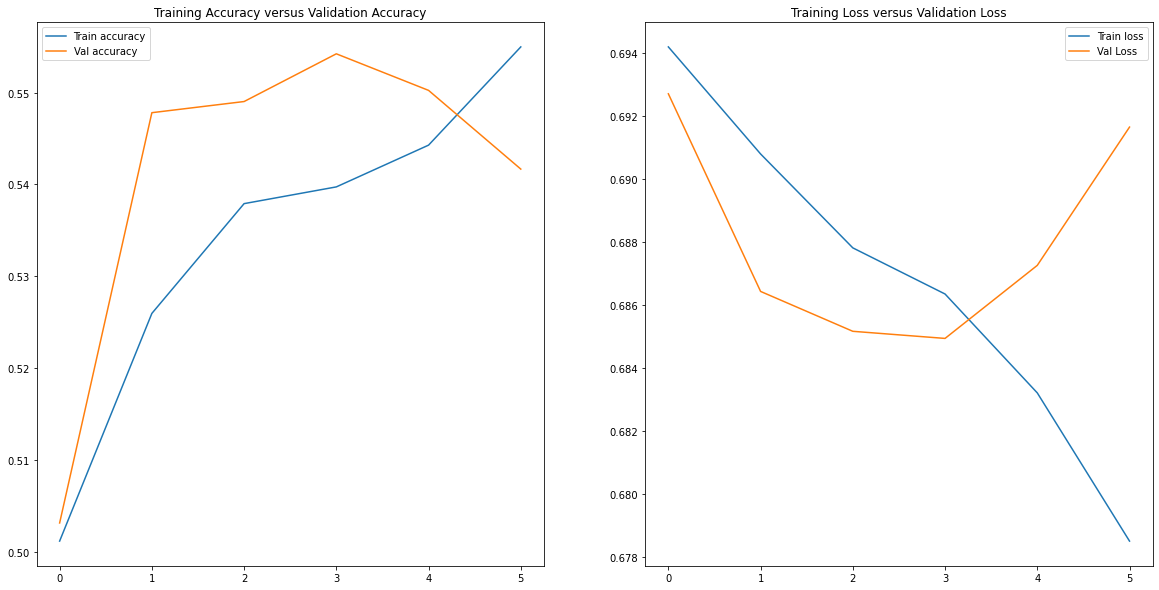

In [12]:
# Plotting Model on Validation Loss and Accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(history.history['accuracy'], label='Train accuracy')
ax1.plot(history.history['val_accuracy'], label='Val accuracy')
ax1.set_title("Training Accuracy versus Validation Accuracy")
ax1.legend()

ax2.plot(history.history['loss'], label='Train loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title("Training Loss versus Validation Loss")
ax2.legend()


There are a few observations from the graphs:

1. The model at the end of the fitting achieved a training accuracy of 56.62% and validation accuracy of 55.19%, which is close to our traditional machine learning models.

2. While the training loss is still decreasing, the validation loss has started to plateau and even increase. This would suggest that model will soon overfit even if the number of epochs increases.


## Predicting on holdout set


The model shall now be trained on the full training set to test on our holdout set.


In [13]:
X_cols = model_df.columns.drop('radiant_win')

In [14]:
X_train = pd.DataFrame(X_train, columns = X_cols)
X_test = pd.DataFrame(X_test, columns = X_cols)

X = pd.concat([X_train, X_test], axis = 0)

In [15]:
y_train = pd.DataFrame(y_train, columns = ['radiant_win']) 
y_test = pd.DataFrame(y_test, columns = ['radiant_win']) 

y = pd.concat([y_train, y_test], axis = 0)

In [16]:
# Training on the full training set
hypermodel = tuner.hypermodel.build(best_hps)

final_model = hypermodel.fit(X, y, epochs=best_epoch, batch_size=128)


Epoch 1/4
1042/1042 [==============================] - 5s 5ms/step - loss: 0.6939 - accuracy: 0.5073
Epoch 2/4
1042/1042 [==============================] - 5s 5ms/step - loss: 0.6894 - accuracy: 0.5336
Epoch 3/4
1042/1042 [==============================] - 5s 5ms/step - loss: 0.6867 - accuracy: 0.5420
Epoch 4/4
1042/1042 [==============================] - 5s 5ms/step - loss: 0.6851 - accuracy: 0.5423


We obtain an accuracy of 57.3% on our full training set.


In [17]:
data_unseen = pd.DataFrame(data_unseen, columns = model_df.columns)

In [18]:
# Creating X and y holdouts
X_holdout = data_unseen.drop(columns=["radiant_win"])
y_holdout = data_unseen['radiant_win']


We can create a confusion matrix to see the display our predictions.


In [19]:
# Generate y prediction values rounded to either 0 or 1

y_pred = round(hypermodel.predict(X_holdout))

print(y_pred)


122/122 [==============================] - 0s 1ms/step
tf.Tensor(
[[0.]
 [0.]
 [1.]
 ...
 [1.]
 [0.]
 [0.]], shape=(3900, 1), dtype=float32)


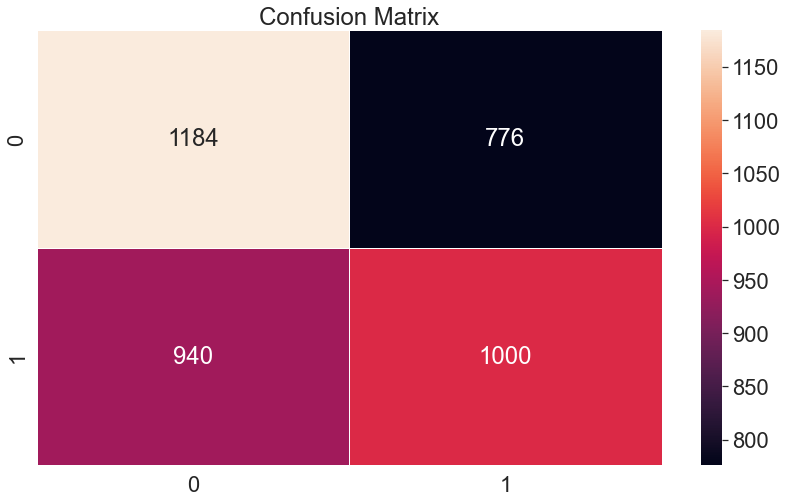

In [20]:
# Generating our confusion matrix

cm = confusion_matrix(y_holdout, y_pred)

plt.figure(figsize=(14, 8))
sns.set(font_scale=2)
p = sns.heatmap(data=cm, annot=True, fmt='d',
                linewidths=.5).set(title='Confusion Matrix')


From the above, we see that the model have predicted 1048 true positives and 1138 true negatives, corresponding to an accuracy of 56%, which is very close to our training accuracy. The model predicts 892 false negatives (22.9%) and 822 false positives(21.1%), which is relatively even between the two.

# Shap Values


We can use Shap Values to interpret our black box model to have a sense of which are the highest contributing features. To minimise processing time, we will be extracting 10% of the train and holdout data to be processed.


In [21]:
# Compute Shap Values

background = X.iloc[np.random.choice(X.shape[0], 14500, replace=False)]

explainer = shap.DeepExplainer(model, background.values)

shap_values = explainer.shap_values(X_holdout[:390].values)


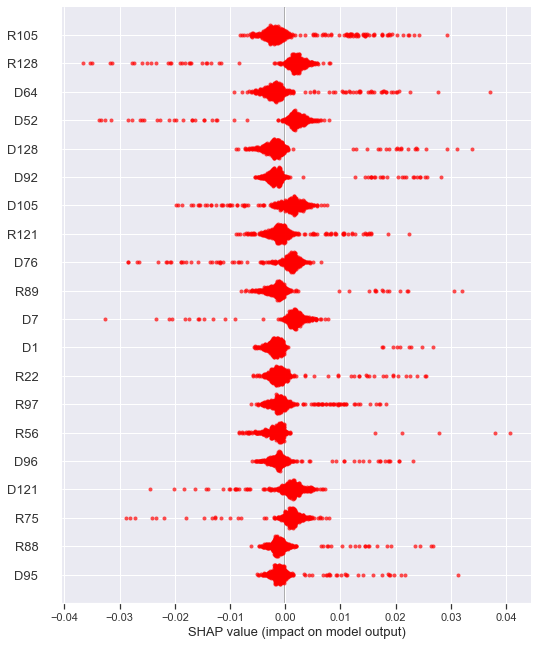

In [22]:
#Plotting in pairs
shap.summary_plot(shap_values[0],  feature_names=X_holdout.columns,
                  color='red', alpha=0.7, title='Top Features')


There are a few observations we can gather from the graph above:

1. Generally, the observations come in pairs (e.g. R92 and D92, D121 and R121 etc), which is unsurprising given that players are randomly assigned in a match to either team . As such, given that we had tried to normalise the skill level between players by choosing only high ranking matches, the hero choice should produce similar contribution from both teams.

2. There are some overlaps with the individual win rates. Looking at the shap values, the top contributing heroes seem to be:

- Visage
- Chen
- Lone Druid
- Lion
- Grimstroke
- Snapfire
- Omniknight

3. Interesting insights into Chen: It seems that on paper, it has a high winrate, yet when played as a team, yet it seems to pull down the probability. Same as Lone Druid.

4. Grimstroke however is the opposite. It has an overall lower winrate, yet the shap values show that having it on your team increases the probability of winning.

5. This suggests that team synergies do affect win rates as well.

As an example, I have extracted a random match to demonstrate how shap values can be interpreted. 

In [23]:
# Plotting individual sample shap value
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(
), shap_values[0][10], features=X_holdout.columns, out_names='Probability')


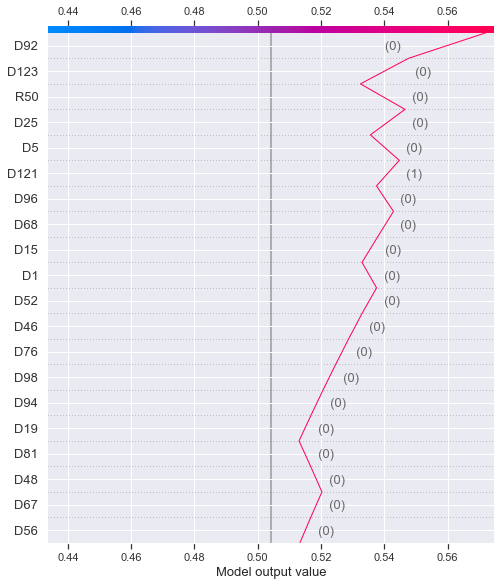

In [24]:
# Plotting individual sample shap decision plot
shap.decision_plot(explainer.expected_value[0].numpy(
), shap_values[0][10], features=X_holdout.iloc[0, :], feature_names=X_holdout.columns.tolist())


In the case above, for this match, the presence of hero R71, corresponding to Spirit Breaker on the radiant team is pushing the probability of team winning downwards. 

# Creating Final Model for Recommender System

Finally, I will train the model on the full dataset for the hero recommender system. 

In [25]:
#Creating split for X and y variables
X_final = model_df.drop('radiant_win', axis = 1)
y_final = model_df['radiant_win']

In [26]:
#Creating the final model using the full dataset
finalmodel = tuner.hypermodel.build(best_hps)

final_model = finalmodel.fit(X_final, y_final, epochs=best_epoch, batch_size=128)


Epoch 1/4
610/610 [==============================] - 4s 5ms/step - loss: 0.6918 - accuracy: 0.5212
Epoch 2/4
610/610 [==============================] - 3s 5ms/step - loss: 0.6850 - accuracy: 0.5535
Epoch 3/4
610/610 [==============================] - 3s 5ms/step - loss: 0.6821 - accuracy: 0.5620
Epoch 4/4
610/610 [==============================] - 3s 5ms/step - loss: 0.6786 - accuracy: 0.5712


In [27]:
# Saving the model file
finalmodel.save('recommender\model.h5')

----
# Conclusion

From the network, the neural network did slightly better than our traditional ML models (58% vs 56% for blended model). While timing would usually be a consideration in deciding which model to use, in this case, timing is not a big factor as compared to accuracy of the model due to the extreme competitive nature of the sport where every increased percentage counts. Hence, I will be using it to be a part of the hero recommender system .

